In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [124]:
# df = pd.read_csv(r'Diabetes Dataset/User_Oriented_Dataset.csv')
df = pd.read_csv(r'Diabetes Dataset/Diabetes_and_LifeStyle_Dataset.csv')

df = df.drop(columns=['systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total',
                 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
                 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 
                 'hba1c', 'diagnosed_diabetes'])

mapping = {
    'No Diabetes': 'Non-Diabetic',
    'Type 1': 'At Risk',
    'Type 2': 'At Risk',
    'Pre-Diabetes': 'At Risk',
    'Gestational': 'At Risk'
}

df['diabetes_stage'] = df['diabetes_stage'].map(mapping)

df.head()

,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,diabetes_risk_score,diabetes_stage
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,29.6,At Risk
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,23.0,Non-Diabetic
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,44.7,At Risk
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,38.2,At Risk
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,23.5,At Risk


In [125]:
# User Oriented Model Features

features = ['Age', 'gender', 'ethnicity', 'smoking_status', \
        'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', \
        'sleep_hours_per_day', 'screen_time_hours_per_day', \
        'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', \
        'bmi', 'waist_to_hip_ratio', 'diabetes_risk_score', 'diet_score']


# Select features and target variable
X = df[features]
y = df['diabetes_stage'] 

print(y.value_counts())

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


numeric_features = [
    'Age',
    'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'bmi',
    'waist_to_hip_ratio'
]

categorical_features = [
    'gender',
    'ethnicity',
    'smoking_status',
    'family_history_diabetes',
    'hypertension_history',
    'cardiovascular_history'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# y_train_encoded = to_categorical(y_train_encoded)
# y_test_encoded = to_categorical(y_test_encoded)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

diabetes_stage
At Risk         89560
Non-Diabetic     7737
Name: count, dtype: int64
(82702,)
(14595,)


In [126]:
# Creating the Model

classes = ['No Diabetes', 'Pre Diabetes', 'Diabetes']

def build_patient_model():
    model = models.Sequential([
        # Input layer
        layers.Dense(128, activation='relu', input_shape=(x_train_processed.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layers
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Initialize Patient-side Model
patient_model = build_patient_model()

patient_model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Implement Early Stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# Train the model
history = patient_model.fit(
    x_train_processed, y_train_encoded,
    epochs=50,
    verbose=1,
    validation_data=(x_test_processed, y_test_encoded),
)


Epoch 1/50


c:\Users\Sydney\Tensorflow\Keras-Diabetes\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2585/2585 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9162 - loss: 0.2725 - val_accuracy: 0.9205 - val_loss: 0.2578
Epoch 2/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9205 - loss: 0.2600 - val_accuracy: 0.9205 - val_loss: 0.2566
Epoch 3/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9205 - loss: 0.2591 - val_accuracy: 0.9205 - val_loss: 0.2579
Epoch 4/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9205 - loss: 0.2583 - val_accuracy: 0.9205 - val_loss: 0.2600
Epoch 5/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9205 - loss: 0.2582 - val_accuracy: 0.9204 - val_loss: 0.2567
Epoch 6/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9205 - loss: 0.2579 - val_accuracy: 0.9204 - val_loss: 0.2570
Epoch 7/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9205 - loss: 0.2578 - val_accuracy: 0.9204 - val_loss: 0.2565
Epoch 8/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9205 - loss: 0.2583 - val_accurac

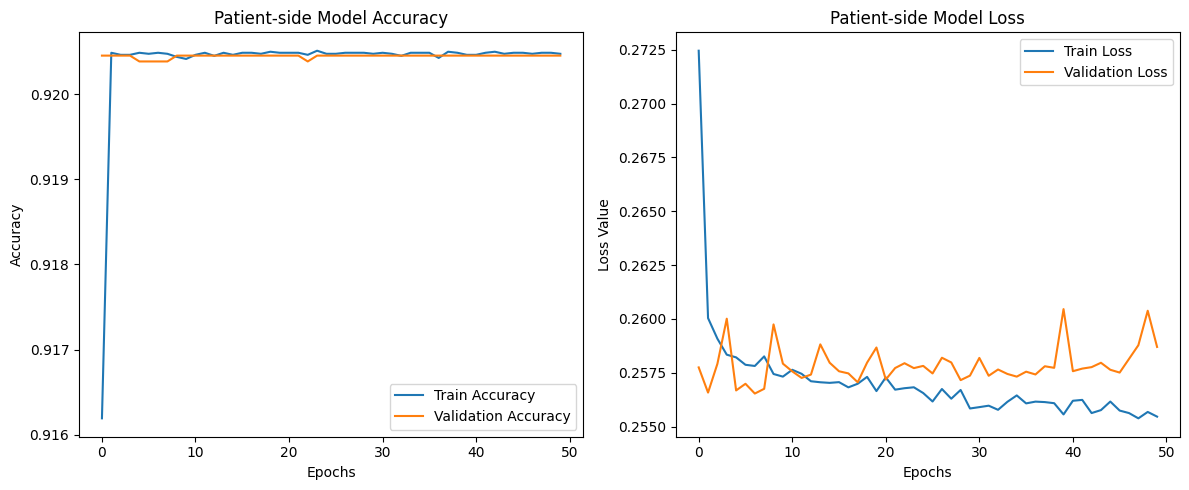

In [127]:
# Visualize Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Patient-side Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Patient-side Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.tight_layout()
plt.show()

In [128]:
# Save the model
# Task: Make a model saving utility that appends version at the end and saves the model
#   Requirements:
#       Format: ModelName_vMajor.Minor.Revisions.h5
#       Version must increment based on the latest version in the Models/

from pathlib import Path
from Utils.versionsys import save_model

model_name = "patient_side_model"
save_path = Path("./Models")
save_model(model=patient_model, model_name=model_name, save_path=save_path, version_increment_type="revision", file_type=".h5")

No existing model exists. Creating patient_side_modelv1.0.0.
